In [1]:
%cd ..

C:\Users\Wight\PycharmProjects\ThesisMain


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from models.SineNet.SineNet_functional import SineNet_functional
from datasets.meta.SineWave_Meta.loading_data import loading_data

In [3]:
sine_net_state = 'save_state_ep_25000.pth'

In [4]:
_, val_loaders, _, _ = loading_data()
criterion = torch.nn.MSELoss()

In [5]:
model = SineNet_functional()

In [6]:
save_state = torch.load('notebooks/SineNetStates/' + sine_net_state)
theta = save_state['net']
for k, v in theta.items():
    v.requires_grad = True

In [7]:
def adapt_on_dataloader(model, theta, val_loader, axis):
    # =============================================================================== #
    #                              GATHER REQUIRED DATA                               #
    # =============================================================================== #
    
    true_wave = val_loader.dataset.task.true_sine(axis)

    x = torch.tensor(axis, dtype=torch.float)  # input to the model
    x = x.unsqueeze(-1).cuda()

    adapt_x, adapt_y = val_loader.dataset.get_adapt_batch()  # datapoints for adaptation
    adapt_x, adapt_y = adapt_x.cuda(), adapt_y.cuda()
    
    # =============================================================================== #
    #                                     BEFORE                                      #
    # =============================================================================== #
    with torch.no_grad():
        pred = model.forward(x, theta)
    pred_before = pred.squeeze().cpu().numpy()


    # =============================================================================== #
    #                                      ADAPT                                      #
    # =============================================================================== #
    theta_values = list(theta[k] for k in theta if not k.startswith('alpha.'))
    theta_names = list(k for k in theta if not k.startswith('alpha.'))
    alpha_values = list(theta[k] for k in theta if k.startswith('alpha.'))

    pred = model.forward(adapt_x, theta)
    loss = criterion(pred, adapt_y)
    grads = torch.autograd.grad(loss, theta_values)

    theta_prime = OrderedDict(
        (n, w - a * g) for n, w, a, g in zip(theta_names, theta_values, alpha_values, grads)
    )

    # =============================================================================== #
    #                                      AFTER                                      #
    # =============================================================================== #
    with torch.no_grad():
        pred = model.forward(x, theta_prime)
    pred_after = pred.squeeze().cpu().numpy()
    
    return true_wave, pred_before, pred_after

In [8]:
def plot_adapt_sinewave(axis, true_wave, pred_before, pred_after):
    plt.figure(figsize=(10,5))
    plt.plot(axis, true_wave, color='green', label='true sine')
    plt.plot(axis, pred_before, color='blue', label='before')
    plt.plot(axis, pred_after, '--', color='red', label='after')
    plt.legend()
    plt.show()

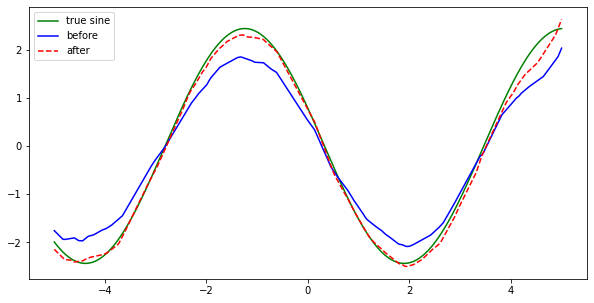

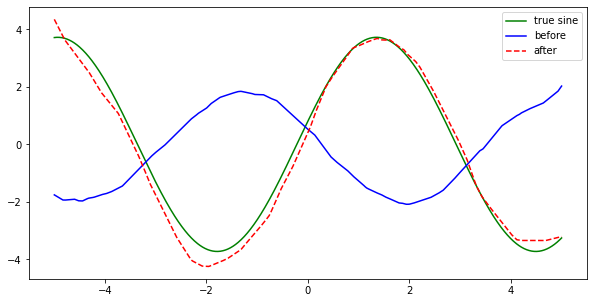

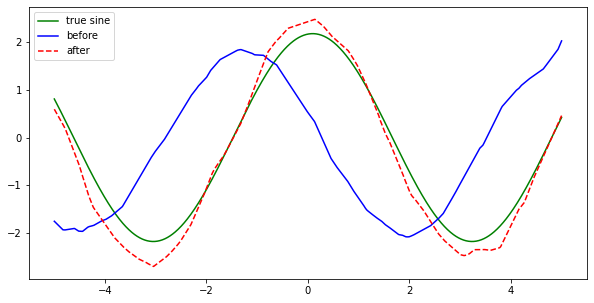

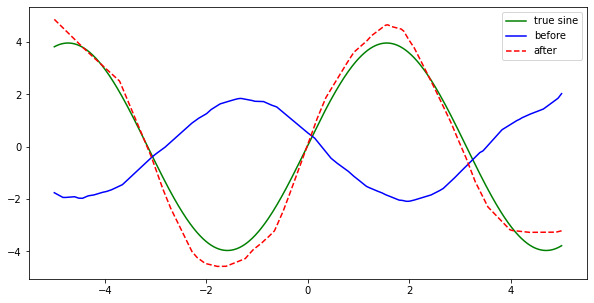

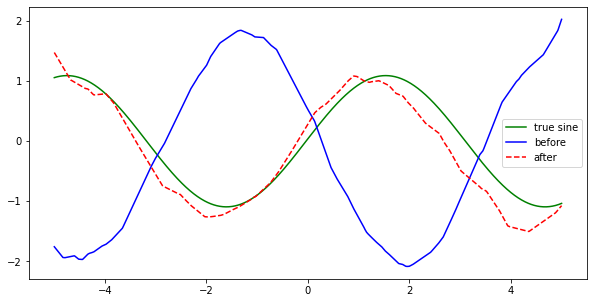

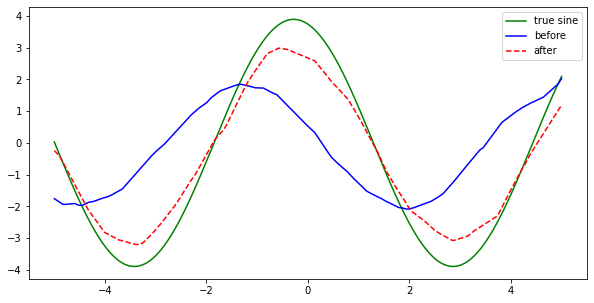

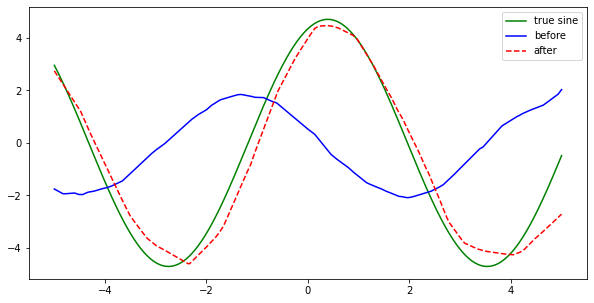

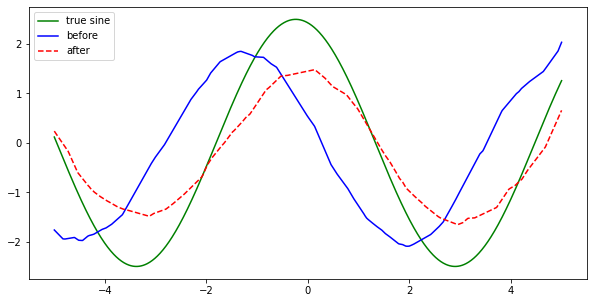

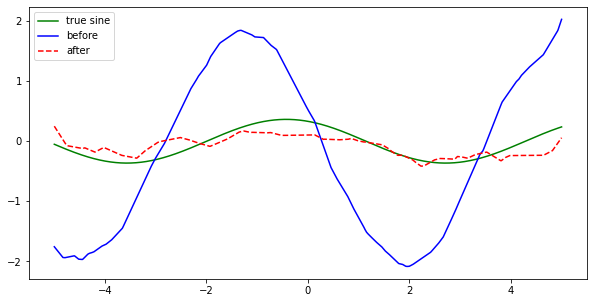

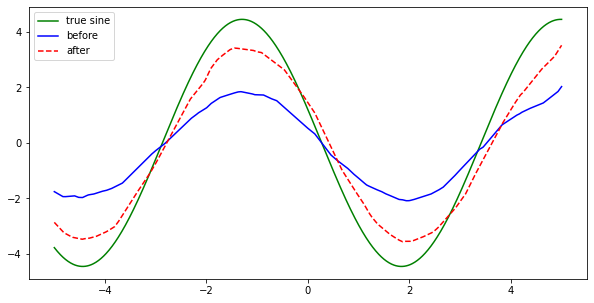

In [9]:
axis = np.linspace(-5, 5, 1000)
for dataloader in val_loaders:
    true_wave, pred_before, pred_after = adapt_on_dataloader(model, theta, dataloader, axis)
    plot_adapt_sinewave(axis, true_wave, pred_before, pred_after)
    